#Прогнозирование SEO-трафика с помощью Google Analytics 4 и Prophet

Мы будем прогнозировать органический трафик (Organic Search) для данных Google Analytics 4, где рассчитанный тренд корректируется с учетом сезонности и предыдущей периодичности. Сделать прогноз можно разными способами и с помощью различных инструментов, но именно в этой статье речь пойдет о Python, API Google Analytics 4, Prophet.

Решение текущей задачи будет состоять из трех основных этапов:

1. получение данных из Google Analytics 4 о SEO-трафике за определенный период времени;
2. моделирование данных с помощью Prophet;
3. визуализация данных — показать изменение тренда и смоделированный прогноз.

## Получение данных из Google Analytics 4
Для того, чтобы получить данные из Google Analytics 4, необходимо:

* создать проект, сервисный аккаунт и включить API Google Analytics в Google Cloud Platform;
* добавить сервисный аккаунт в ресурс Google Analytics 4;
загрузить файл в сессионное хранилище Colab;
* установить библиотеку `google-analytics-data` для Python;
* написать код извлечения данных.

Разберем каждый шаг подробнее.

### Настройки в Google Cloud Plaftorm
Перейдите [по ссылке](https://console.cloud.google.com/) и создайте новый проект в Google Cloud Platform.

Выбрав созданный проект, в поиске введите Google Analytics Data API и включите API Google Analytics.

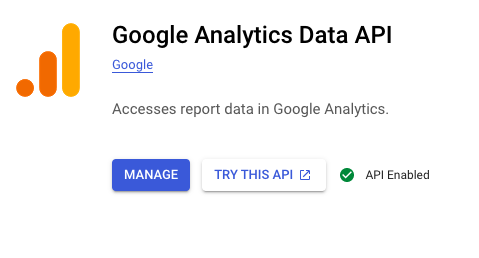

Затем перейдите в раздел IAM & Admin – Service Accounts.

Создайте сервисный аккаунт через Create Service Account.

После создания сервисного аккаунта, вы увидите его в общем списке. 

Напротив него нажмите на иконку с тремя точками и выберите Manage keys, затем создайте новый ключ формата JSON: Add key – Create new key.

После этого будет создан файл, который автоматически сохранится у вас локально на компьютере.

### Добавление сервисного аккаунта в Google Analytics 4

Скопируйте email из сервисного акаунта Google Cloud. Откройте свой ресурс Google Analytics 4, с которым планируете работать и для которого будете делать прогноз трафика. Перейдите в раздел Администратор – Ресурс — Управление доступом к ресурсу.
Добавьте нового пользователя — для работы с Google Analytics Data API v1 необходимы только разрешения на чтение и анализ. В поле адреса электронный почты добавьте скопированный на предыдущем шаге e-mail сервисного аккаунта.

### Получение данных из Google Analytics 4

В левом меню нажмите на иконку папки и загрузите файл в формате json в сессионное хранилище, который вы получили в Google Cloud Plaftorm после создания сервисного аккаунта.

Теперь вы можете извлечь данные, отправив запрос к API Google Analytics 4. В [официальной документации](https://developers.google.com/analytics/devguides/reporting/data/v1/quickstart-client-libraries) есть примеры запросов на Python для получения статистики по нужным параметрам и показателям.

In [ ]:
#!pip install google-analytics-data

In [ ]:
import os
import holidays
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import (DateRange, Dimension, Metric, 
                                                Filter, FilterExpression, 
                                                FilterExpressionList, 
                                                RunReportRequest)

PROPERTY_ID = '334937235'
START_DATE = '2019-10-01'
END_DATE = 'today' # '2022-9-30'

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/ga-data-364000-2bbf7c4b77ce.json"

def ga4_fetch(property_id, start_date, end_date, source='Organic Search'):
  client = BetaAnalyticsDataClient()
  request = RunReportRequest(
      property=f'properties/{property_id}',
      dimensions=[Dimension(name='date')],
      metrics=[Metric(name='eventCount')],
      date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
      dimension_filter=FilterExpression(and_group=FilterExpressionList(
          expressions=[
              FilterExpression(filter=Filter(
                  field_name='sessionDefaultChannelGrouping',
                  string_filter=Filter.StringFilter(
                      value=source,
                      match_type=Filter.StringFilter.MatchType(1)
                      )
                  )),
              FilterExpression(filter=Filter(
                  field_name='eventName',
                  string_filter=Filter.StringFilter(
                      value='session_start',
                      match_type=Filter.StringFilter.MatchType(1)
                      )
                  ))
              ]))
      )
  
  response = client.run_report(request)
  
  #print("Report result:")
  #for row in response.rows:
  #  print(row.dimension_values[0].value, row.metric_values[0].value)
  
  return response

fetched_data = ga4_fetch(PROPERTY_ID, START_DATE, END_DATE)

Этот запрос позволяет получить информацию по вашим сеансам с источникам трафика Organic Search за установленный период. В качестве определения количества сеансов используется фильтр по событию `session_start`, которое срабатывает тогда, когда пользователь начинает новый сеанс на вашем сайте. Итоговый подсчет идет именно по ним.

Любой параметр, показатель, фильтр, порядок данных, диапазон дат и т.д., добавленные в переменную запроса, должны быть добавлены как класс.

In [ ]:
def get_values(row):
  dimention = row.dimension_values[0].value
  metric = row.metric_values[0].value
  return dimention, metric

In [ ]:
df = pd.DataFrame([get_values(row) for row in fetched_data.rows],
                  columns=['Date', 'Visits']).astype({'Date': 'datetime64'})

Как вы уже знаете, чем больше у вас будет исторических данных, тем точнее будет ваша модель и, следовательно, прогноз. Поэтому рекомендуется выгружать данные из Google Analytics 4 за больший период, чем месяц.

---

## Прогнозирование с помощью библиотеки Prophet
В настоящее время существует множество бесплатных и готовых библиотек для выполнения любого типа прогнозирования на основе исторических данных. В текущем анализе будем использовать библиотеку Prophet от Facebook.

В основе прогноза лежит процедура подгонки аддитивных регрессионных моделей, в которой нелинейные тренды корректируются с учетом ежедневной сезонности, еженедельных и годовых значений, а также учитываются последствия отпускных дней и праздников (например, официальные праздничные и выходные дни — Новый год, Рождество, спортивные мероприятия, культурные события, природные явления. В такие дни поведение и свойства временных рядов могут существенно меняться/колебаться, вызывать всплески и серьезные отклонения. В Prophet вы можете это учесть и гибко настроить условия прогноза благодаря доступным переменным.

Для прогнозирования и визуализации полученных данных нам необходимы библиотеки `prophet`, `pystan`, `pandas`, `matplotlib`, `holidays`. В Colab они уже все предустановлены, поэтому дальнейший процесс прогноза существенно сокращается.

### Работа с Prophet

* создается экземпляр объекта Prophet с нужными атрибутами для прогноза;
запрашивается метод подгонки для данных, извлеченных из Google Analytics 4, в виде датафрейма. В некоторых случаях этот запрос может занять несколько секунд. Входные данные для Prophet всегда представляют собой датафрейм с двумя столбцами: `ds` и `y`. Столбец `ds` (отметка даты) должен иметь формат даты. Столбец `y` (метрика для изучения/прогноза) должен быть числовым;
* для полученного датафрейма задается количество периодов, до которых должен достигаться прогноз из выбранного диапазона дат, и частоту, с которой данные будут агрегироваться (еженедельно, ежемесячно и т.д.);
* запрашивается метод `predict`, который назначит каждой строке будущего датафрейма прогнозируемое значение `yhat`;
* запрашивается метод `plot`, чтобы иметь возможность просматривать сгенерированные прогнозы;
* запрашивается метод `plot_components`, который помогает визуально понять тенденцию и сезонность данных.

Prophet очень гибок в настройке и имеет большое количество разных функций.

Наша главная цель — создать прогноз для органического поиска наших данных Google Analytics 4, придерживаясь определенной логике. Например, учитывать снижение количества трафика в выходные и праздничные дни, исключить выбросы, если они имеют место быть, выбрать сезонную модель (аддитивная и мультипликативная сезонность) и т.д.

В отличие от других каналов (например, рекламный трафик, e-mail рассылки или посты в социальных сетях), SEO-трафик обычно имеет мало заметных колебаний (впадин или пиков). Он имеет тенденцию к постепенному росту или снижению с течением времени, и иногда на него влияют сезонные явления. Обычно заметные колебания связаны с обновлениями в алгоритме поисковых систем (Google, Яндекс, Bing и т.д.).

### Настройка гиперпараметров модели

* `growth` — тип тренда. Принимает два возможных значения: линейный по умолчанию (`linear`) и логистический (`logistic`);
* `changepoint_prior_scale` — параметр, задающий чувствительность автоматического механизма обнаружения точек излома в тренде временного ряда `y` (0.05 по умолчанию). Более высокие значение позволят иметь больше таких точек излома (что одновременно увеличит риск переобучения модели);
* `seasonality_mode` — режим моделирования сезонных компонент. Принимает два возможных значения: аддитивный по умолчанию (`additive`) и мультипликативный (`multiplicative`);
* `daily_seasonality` — параметр настройки дневной сезонности (т.е. закономерных колебаний в пределах дня). Принимает следующие возможные значения: `auto` (автоматический режим, принят по умолчанию), TRUE, FALSE или количество членов ряда Фурье, с помощью которого аппроксимируется компонента годовой сезонности;
* `weekly_seasonality` — параметр настройки недельной сезонности (т.е. закономерных колебаний в пределах недели). Возможные значения те же, что и у `daily_seasonality`;
* `yearly_seasonality` — параметр настройки годовой сезонности (т.е. закономерных колебаний в пределах года). Возможные значения те же, что и у `daily_seasonality`;
* `holidays` — параметр учитывает фактор праздников (Новый год, Рождество, спортивные мероприятия, культурные события, природные явления). Настраиваются с помощью дополнительного атрибута `holidays_prior_scale`.

Подробнее о параметрах читайте в [официальной документации](https://facebook.github.io/prophet/docs/diagnostics.html).

### Получение данных о праздничных днях

In [ ]:
holidays_dict = holidays.RU(years=range(df['Date'].min().year,
                                        df['Date'].max().year+1))
df_holidays = pd.DataFrame.from_dict(holidays_dict,
                                     orient='index',
                                     columns=['holiday']) \
                          .reset_index() \
                          .rename({'index': 'ds'}, axis='columns') \
                          .astype({'ds': 'datetime64'}) \
                          .sort_values(by=['ds'])

df_holidays.head()

,ds,holiday
0,2019-01-01,Новый год
1,2019-01-02,Новый год
2,2019-01-03,Новый год
3,2019-01-04,Новый год
4,2019-01-05,Новый год


### Гиперпараметры предиктивной модели

In [ ]:
params = dict(
    growth="linear",   
    seasonality_mode='additive',                  
    changepoint_range=0.9,                   
    changepoint_prior_scale=0.01,
    interval_width=0.9,
    uncertainty_samples=300,
    holidays=df_holidays
)

### Обучение модели и предскзание будущих значений

In [ ]:
def forecasting(df, params, period=6, freq='M', floor=None, cap=None):
    df.columns = ['ds', 'y']  
    if floor: df = df.assign(floor=floor, cap=cap)
    
    model = Prophet(**params).fit(df)
    future = model.make_future_dataframe(periods=period, freq=freq)
    if floor: future = future.assign(floor=floor, cap=cap)
    forecast = model.predict(future)
 
    fig = model.plot(forecast, xlabel='Date', ylabel='Visits')
    add_changepoints_to_plot(fig.gca(), model, forecast)
    model.plot_components(forecast)
    plt.show()

### Визуализация данных
Мы также визуализируем компоненты прогноза с помощью метода `plot_components(forecast)` и добавляем к ним точки изменения тренда `trend changepoints` с помощью функции `add_changepoints_to_plot` для выявления переломных моментов на графике, то есть когда произошли существенные изменения в тренде временного ряда.

Для демонстрации работы библиотеки Prophet я выгрузил данные по органическому трафику из счетчика Google Analytics 4 с 1 октября 2019 года по 30 сентября 2022 года, а в качестве периода прогнозирования указал 6 месяцев с разбиением по месяцам. После выполнения кода я получил такие графики и значения:



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps0debq_g/cqpvjp01.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps0debq_g/3toh_fkf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77294', 'data', 'file=/tmp/tmps0debq_g/cqpvjp01.json', 'init=/tmp/tmps0debq_g/3toh_fkf.json', 'output', 'file=/tmp/tmpv2j6klqx/prophet_model-20221002162046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:20:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:20:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


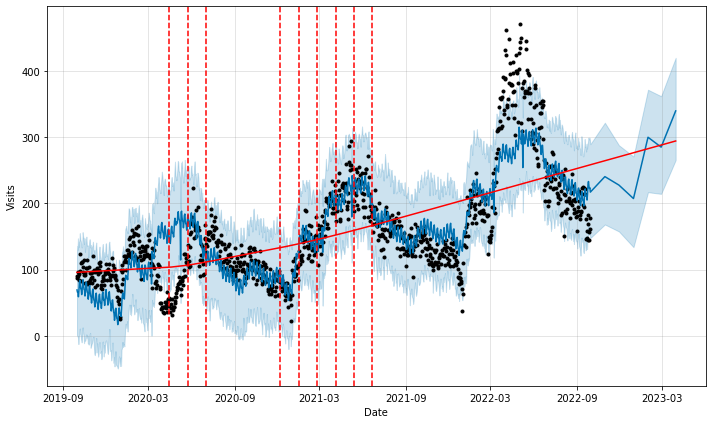

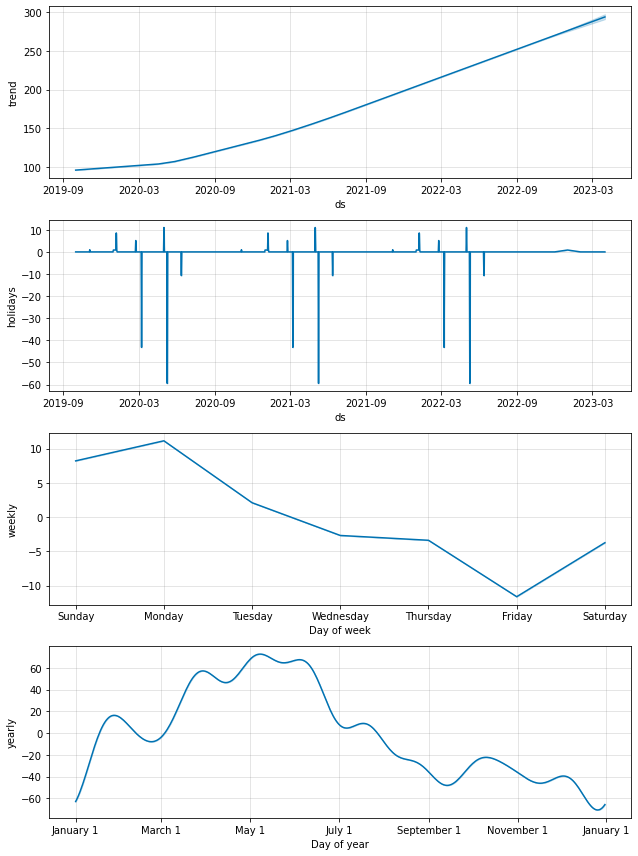

In [ ]:
forecasting(df, params, floor=0, cap=600)

По оси X отложены даты с учетом прогноза, а по оси Y отображаются данные по органическому трафику. Prophet включил исходные данные в виде черных точек, а синяя линия — это модель прогноза. Голубая область — доверительный интервал. С помощью функции `add_changepoints_to_plot` добавлены красные линии: вертикальные пунктирные линии — это точки изменения, которые Prophet определил, где изменился тренд, а сплошная красная линия — это тренд с удалением всей сезонности.